# Convolutional Neural Networks usando Keras e CIFAR-10

### 1. Carregando a base CIFAR-10 (imagens rotuladas em macro categorias)

*** Mais informações em https://www.cs.toronto.edu/~kriz/cifar.html ***

In [15]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator 
from keras import regularizers

In [16]:
#carregando o dataset pré-embaralhado de treinamento bem como os dados de teste
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### 2. Visualizando as primeiras 24 imagens do dataset de treinamento

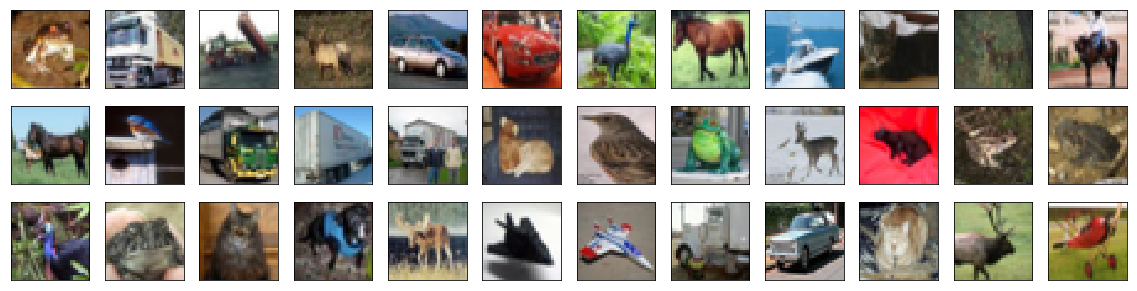

In [17]:
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### 3. Redimensionando as imagens e dividindo cada pixel em cada imagem por 255

In [18]:
# redimensionamento [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 4.  Dividindo o dataset em treinamento, teste e validação

In [19]:
# "one-hot encode" aplicado aos rótulos
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# divindo dataset de treinamento em treinamento, teste e validação
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# impressão da forma do conjunto de treino
print('x_train shape:', x_train.shape)

# impressão do número de imagens nos datasets de treinamento, teste e validação
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Definindo a arquitetura do modelo (IMPORTANTE!)

* 3 camadas convolucionais de tamanho progressivamente crescente
* Máximo de camadas de "pooling" (2x2) seguidas por tais 3 camadas convolucionais
* Uma camada do tipo totalmente conectada de 100 neurônios
* Últimas camadas do tipo totalmente conectadas de 10 saídas (10 classes de categoria de imagem)
* "Dropout" de 0,2-0,3

In [20]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='elu',
                 kernel_regularizer = regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='elu',
                 kernel_regularizer = regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='elu',
                 kernel_regularizer = regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

# tentem com outras funções de ativação (como visto em nossa Aula 3)
    # mais informações em https://keras.io/activations/

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
__________

### 6. Data Augmentation

In [21]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

### 7. Compilando o modelo

In [22]:
# compilando o modelo escolhendo como se dará nossa perda, otimização e métricas (parâmetros do Keras)
# mais informações em https://keras.io/losses/
# mais informações em https://keras.io/optimizers/
# mais informações em https://keras.io/metrics/
optimizer = keras.optimizers.rmsprop(lr = 0.001, decay = 0.000001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### 8. Treinando o modelo

In [23]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
bs = 128
epochs = 100

start = time.time()

hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=bs), epochs=epochs, 
                           steps_per_epoch=math.ceil(x_train.shape[0]//bs), validation_data=(x_valid, y_valid),
                           callbacks=[checkpointer], verbose=2, shuffle=True)

end = time.time()
print("Tempo de treinamento: " + str(end - start) + "s")

# tentem mudar o número de épocas de treinamento e verificar o comportamento de nosso algoritmo

Epoch 1/100
 - 15s - loss: 1.9674 - acc: 0.2950 - val_loss: 1.6698 - val_acc: 0.4114

Epoch 00001: val_loss improved from inf to 1.66977, saving model to model.weights.best.hdf5
Epoch 2/100
 - 15s - loss: 1.6706 - acc: 0.4005 - val_loss: 1.6631 - val_acc: 0.4600

Epoch 00002: val_loss improved from 1.66977 to 1.66308, saving model to model.weights.best.hdf5
Epoch 3/100
 - 14s - loss: 1.5492 - acc: 0.4513 - val_loss: 1.4629 - val_acc: 0.5250

Epoch 00003: val_loss improved from 1.66308 to 1.46287, saving model to model.weights.best.hdf5
Epoch 4/100
 - 15s - loss: 1.4598 - acc: 0.4846 - val_loss: 2.9546 - val_acc: 0.4232

Epoch 00004: val_loss did not improve from 1.46287
Epoch 5/100
 - 15s - loss: 1.4057 - acc: 0.5091 - val_loss: 1.1447 - val_acc: 0.5998

Epoch 00005: val_loss improved from 1.46287 to 1.14468, saving model to model.weights.best.hdf5
Epoch 6/100
 - 15s - loss: 1.3515 - acc: 0.5339 - val_loss: 1.1165 - val_acc: 0.6366

Epoch 00006: val_loss improved from 1.14468 to 1.1164

 - 14s - loss: 0.9106 - acc: 0.7089 - val_loss: 0.7383 - val_acc: 0.7712

Epoch 00056: val_loss did not improve from 0.70891
Epoch 57/100
 - 14s - loss: 0.9065 - acc: 0.7121 - val_loss: 0.7268 - val_acc: 0.7850

Epoch 00057: val_loss did not improve from 0.70891
Epoch 58/100
 - 14s - loss: 0.9034 - acc: 0.7107 - val_loss: 0.8234 - val_acc: 0.7504

Epoch 00058: val_loss did not improve from 0.70891
Epoch 59/100
 - 14s - loss: 0.9036 - acc: 0.7143 - val_loss: 0.7579 - val_acc: 0.7698

Epoch 00059: val_loss did not improve from 0.70891
Epoch 60/100
 - 15s - loss: 0.8959 - acc: 0.7146 - val_loss: 0.6812 - val_acc: 0.7964

Epoch 00060: val_loss improved from 0.70891 to 0.68119, saving model to model.weights.best.hdf5
Epoch 61/100
 - 15s - loss: 0.8990 - acc: 0.7140 - val_loss: 0.7976 - val_acc: 0.7514

Epoch 00061: val_loss did not improve from 0.68119
Epoch 62/100
 - 14s - loss: 0.8950 - acc: 0.7173 - val_loss: 1.0356 - val_acc: 0.6794

Epoch 00062: val_loss did not improve from 0.68119
Ep

### 9. Carregando o modelo com a melhor precisão de validação

In [24]:
# carregando os pesos que geraram a melhor precisão de validação
model.load_weights('model.weights.best.hdf5')

### 10. Cálculo da precisão de classificação no dataset de testes

In [25]:
# avaliar e imprimir a precisão do teste
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test loss:', score[0])
print('\n', 'Test accuracy:', score[1])


 Test loss: 0.6681417414188385

 Test accuracy: 0.7986


### 11. Visualizar algumas predições

As visualizações podem nos dar algumas dicas sobre por que a rede classifica erroneamente alguns objetos.

In [26]:
# obtendo previsões no conjunto de testes
y_hat = model.predict(x_test)

# definindo rótulos de texto (rótulos disponíveis na fonte original: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

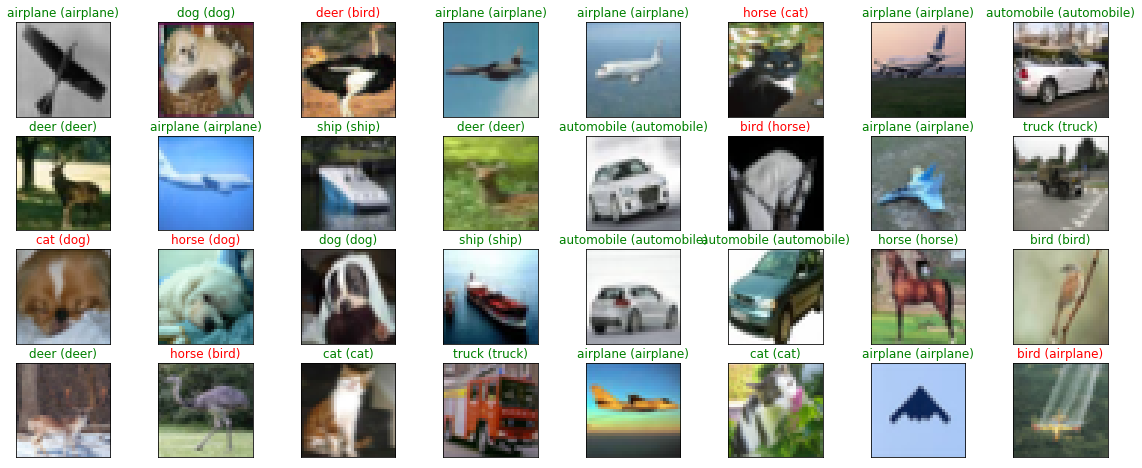

In [27]:
# plot de amostra aleatória de imagens de teste, rótulos preditos e a "ground truth" advinda do dataset CIFAR-10
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
    # amostras corretamente classificadas em verde, incorretamente classificadas em vermelho
